# What Twitter Tactics Were Used To Try To Influence The 2016 US Election?

This is my first foray into analyzing data publicly, so bear with me. There are a number of interesting, basic questions that might be asked of this collection of tweets from Russian bots/humans intending to influence Americans before and after the 2016 Presidential Election, for example:

* Who are the users doing the tweeting - are they 'popular' accounts?
* What fraction of the tweets are original content (not retweeted content)?
* Among the retweets, what fraction are retweeting other Russian users? What fraction are retweeting outside users?
* Who are the most retweeted Russian users? The most retweeted outside users? The most prolific tweeters? And what fraction of their content is original?
* Is there a typical tweeting time over the course of a 24 hour period? For users posting mostly original content? For the top tweeters? Top retweeted? For users posing as news sites?
* Is there a typical pattern of retweets from one user to another? How does a tweet move between users?
* How are users connected to each other through their retweeting patterns?
* Are there any differences in language usage between tweets that originate from the Russian user set as compared to content that is retweeted from outside of the user set? Were there differences in language usage over time? Were other Republicans from the primary treated similarly to Donald Trump in the early days of the campaign?

Some thoughts about the dataset itself:
It is probable that this dataset is not comprehensive, so there may be Russian trolls that will be falsely identified as 'real' people, only because they were not included in this dataset. I am also unsure of the timezone that the tweets were created in, so there may be an issue with analyzing the patterns of tweets over a 24 hour period. I have made the assumption that the tweet time stamps are all presented in the same time zone (although which time zone, I am not sure).


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['users.csv', 'tweets.csv']


In [2]:
#Read in 'User' dataset containing information about users
users = pd.read_csv('../input/users.csv')
#Read in 'tweets' dataset containing actual tweets
tweets = pd.read_csv('../input/tweets.csv')

## First let's just take a look at the two dataframes...starting with the `users` dataframe

In [3]:
#First five rows of users dataset
users.head()

,id,location,name,followers_count,statuses_count,time_zone,verified,lang,screen_name,description,created_at,favourites_count,friends_count,listed_count
0,18710816.0,near Utah Ave & Lighthouse an,Robby Delaware,304.0,11484.0,Pacific Time (US & Canada),False,en,RobbyDelaware,"I support the free movement of people, ideas a...",Wed Jan 07 04:38:02 +0000 2009,17.0,670.0,13.0
1,100345056.0,still ⬆️Block⤵️Corner⬇️street,#Ezekiel2517✨...,1053.0,31858.0,NaN,False,en,SCOTTGOHARD,CELEBRITY TRAINER ✨#424W147th✨ #CrossfitCoach ...,Tue Dec 29 23:15:22 +0000 2009,2774.0,1055.0,35.0
2,247165706.0,"Chicago, IL",B E C K S T E R✨,650.0,6742.0,Mountain Time (US & Canada),False,en,Beckster319,Rebecca Lynn Hirschfeld Actress.Model.Writer.A...,Fri Feb 04 06:38:45 +0000 2011,7273.0,896.0,30.0
3,249538861.0,NaN,Chris Osborne,44.0,843.0,NaN,False,en,skatewake1994,NaN,Wed Feb 09 07:38:44 +0000 2011,227.0,154.0,1.0
4,449689677.0,NaN,Рамзан Кадыров,94773.0,10877.0,Moscow,False,ru,KadirovRussia,"Пародийный аккаунт. Озвучиваю то, что политика...",Thu Dec 29 11:31:09 +0000 2011,0.0,7.0,691.0


The `users` dataset has a number of columns that might be interesting to explore further, including the `created_at` column and the `followers_count` vs `friends_count` columns. 
* the `created_at` column might help us understand how far in advance these accounts were created prior to the election and might shed some light on the degree of planning that went into this.
* a comparison of the `followers_count` vs `friends_count` might help us understand how 'popular' these accounts were. For example, I imagine most celebrities would have a high follower-to-friend ratio. A low ratio, or a ratio close to one, would indicate that influence on twitter was cultivated by making lots of friend requests to 'real' people.

In [4]:
#create a simplified users dataset
users = users.iloc[:,[0,3,7,8,10,12]]
users.head()

,id,followers_count,lang,screen_name,created_at,friends_count
0,18710816.0,304.0,en,RobbyDelaware,Wed Jan 07 04:38:02 +0000 2009,670.0
1,100345056.0,1053.0,en,SCOTTGOHARD,Tue Dec 29 23:15:22 +0000 2009,1055.0
2,247165706.0,650.0,en,Beckster319,Fri Feb 04 06:38:45 +0000 2011,896.0
3,249538861.0,44.0,en,skatewake1994,Wed Feb 09 07:38:44 +0000 2011,154.0
4,449689677.0,94773.0,ru,KadirovRussia,Thu Dec 29 11:31:09 +0000 2011,7.0


## ...Now let's look at the `tweets` dataframe

In [5]:
#Let's look at the first 5 rows of the tweets dataset
tweets.head()

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,NaN,NaN,NaN,#IslamKills Are you trying to say that there w...,7.123460e+17,NaN,"[""IslamKills""]",[],POSTED,[],NaN,NaN
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,0.0,False,0.0,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...",[],"[""http://detne.ws/2e172jF""]",POSTED,[],NaN,NaN
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,NaN,NaN,NaN,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,NaN,[],[],POSTED,[],NaN,NaN
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,NaN,NaN,NaN,RT @jww372: I don't have to guess your religio...,8.134006e+17,NaN,"[""ChristmasAftermath""]",[],POSTED,[],NaN,NaN
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,NaN,NaN,NaN,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,NaN,[],[],POSTED,[],NaN,NaN


The `tweets` dataset likewise has a number of columns that will be interesting to explore, including:
* `user_key`
* `created_str`
* `text`

The `user_key` column may be used to link the `tweets` dataset to the `users['screen_name']` column.

The `created_str` column will allow us to ask the questions: 
When are these tweets generated over the course of a 24 hour period? Is there a common pattern?
and
Is there a typical retweeting pattern?

The `text` column can be used to extract the source of a retweet and study the fraction of retweets vs original content.

In [6]:
#create a simplified tweets df
tweets = tweets.iloc[:,[0,1,2,3,7,8,10]]
tweets.head()

,user_id,user_key,created_at,created_str,text,tweet_id,hashtags
0,1.868981e+09,ryanmaxwell_1,1.458672e+12,2016-03-22 18:31:42,#IslamKills Are you trying to say that there w...,7.123460e+17,"[""IslamKills""]"
1,2.571870e+09,detroitdailynew,1.476133e+12,2016-10-10 20:57:00,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,[]
2,1.710805e+09,cookncooks,1.487767e+12,2017-02-22 12:43:43,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,[]
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,RT @jww372: I don't have to guess your religio...,8.134006e+17,"[""ChristmasAftermath""]"
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,[]


## Let's begin by looking at relationship between the number of friends and followers for each user to see if there are some users that are more 'popular'

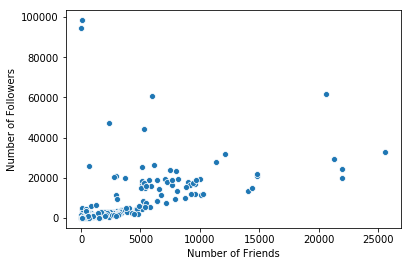

In [7]:
#Plot the relationship between the number of a user's "friends" and "followers"
sns.scatterplot(x=users['friends_count'], y=users['followers_count'])
plt.xlabel('Number of Friends')
plt.ylabel('Number of Followers')
plt.show()

This plot shows a pretty clear linear relationship for most users where the number of followers is ~ equal to the the number of friends, but there are a few outliers in the top left of the scatter plot. Let's take a closer look at those users.

In [8]:
#subset and copy users df to include only users with 'friend_count' > 0
clean_users = users[users['friends_count'] > 0].copy()
#create new column containing the ratio for follower to friends
clean_users['f_f_ratio'] = clean_users['followers_count'] / clean_users['friends_count']
clean_users['f_f_ratio'].describe(percentiles = [0.5,0.6,0.7,0.8,0.9])

count      383.000000
mean        41.106440
std        693.615068
min          0.000000
50%          1.112583
60%          1.195281
70%          1.302326
80%          1.860003
90%          5.265994
max      13539.000000
Name: f_f_ratio, dtype: float64

In [9]:
#subset users data based on the f_f_ratio, using a threshold of 2 followers to friends
popular = clean_users[clean_users['f_f_ratio'] > 2].copy()
unpopular = clean_users[clean_users['f_f_ratio'] < 2].copy()
per_popular = popular.shape[0] / clean_users.shape[0] *100
print(per_popular)

18.79895561357702


19% of accounts have 2-fold more followers than friends. Who are these accounts that are so popular?

In [10]:
popular.sort_values(['f_f_ratio'],ascending=False).head(10)

,id,followers_count,lang,screen_name,created_at,friends_count,f_f_ratio
4,4.496897e+08,94773.0,ru,KadirovRussia,Thu Dec 29 11:31:09 +0000 2011,7.0,13539.000000
315,2.808834e+09,98412.0,ru,MaxDementiev,Sun Sep 14 06:20:01 +0000 2014,94.0,1046.936170
108,2.494510e+09,4515.0,ru,Kotovamarys,Wed May 14 18:11:36 +0000 2014,62.0,72.822581
113,2.512420e+09,4507.0,ru,russilanrogov,Sun Apr 27 11:14:41 +0000 2014,75.0,60.093333
318,2.519635e+09,4749.0,ru,MaksBlaginin,Wed Apr 30 19:27:41 +0000 2014,84.0,56.535714
312,2.579089e+09,2347.0,ru,LysikVinkova,Fri Jun 20 18:20:57 +0000 2014,49.0,47.897959
322,2.542877e+09,2305.0,ru,RogovIlia,Mon May 12 12:09:09 +0000 2014,52.0,44.326923
141,2.541215e+09,2160.0,ru,GvardeykaLena,Sun May 11 15:53:17 +0000 2014,50.0,43.200000
334,2.589513e+09,26002.0,ru,zubovnik,Thu Jun 26 12:46:20 +0000 2014,657.0,39.576865
326,8.758894e+07,1267.0,ru,anzgri,Thu Nov 05 01:44:48 +0000 2009,36.0,35.194444


It looks like the majority of these popular users are Russian.

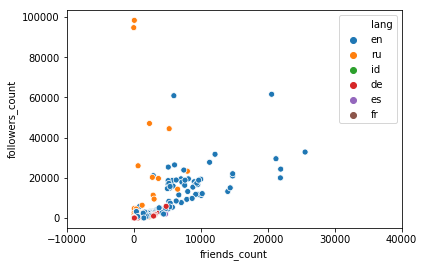

In [11]:
#Plot 'friends' vs. 'followers' with points colored by language
sns.scatterplot(x='friends_count',y='followers_count',hue='lang',data=clean_users)
plt.xlim(-10000,40000)
plt.show()

This plot confirms what we saw above that many of the most popular accounts are russian language accounts

In [12]:
print('Fraction of popular accounts that are Russian language users')
print(popular[popular['lang']=='ru'].shape[0]/popular.shape[0])

Fraction of popular accounts that are Russian language users
0.6388888888888888


Over 60% of the most popular accounts are Russian language users. Who are the users that speak english and are popular?

In [13]:
#subset popular df by english language users
en_pop = popular.loc[popular['lang'] == 'en','screen_name'].str.lower().values
print(en_pop)
    

['jassscott' 'antonhayhay' 'warfareww' 'dailysanfran' 'chicagodailynew'
 'onlinememphis' 'detroitdailynew' 'russianallies' 'kansasdailynews'
 'todaypittsburgh' 'philadelphiaon' 'dailylosangeles' 'washingtonline'
 'todaynycity' 'onlinecleveland' 'phoenixdailynew' 'sanantotopnews'
 'jenn_abrams' 'newspeakdaily' 'todayinsyria' 'neworleanson'
 'elpasotopnews' 'seattle_post' 'dailysandiego' 'dallastopnews'
 'ttsvetkov']


Interestingly many of these English language users with a high follower to friend ratio appear to be posing as news sites

Let's now look to see how active these popular vs unpopular accounts were in the `tweets` df.

In [14]:
#convert popular users' screen names to 'user_key' format
pop_peeps = popular['screen_name'].str.lower().values
#convert unpopular users' screen names to 'user_key' format
unpop_peeps = unpopular['screen_name'].str.lower().values
#no_friends 'user_keys'
no_friends = users.loc[users['friends_count'] == 0,'screen_name'].str.lower().values
#all 'user_keys'
all_users = users['screen_name'].str.lower().values

In [15]:
#count total number of tweets in tweets df for popular vs unpopular vs all users
name_list = ['popular','unpopular','all']
list_list = [pop_peeps,unpop_peeps,all_users]
count_list = []
for el in list_list:
    count = 0
    for peep in el:
        pop = tweets[tweets['user_key'] == peep]
        count += pop.shape[0]
    count_list.append(count)
for i in range(0,3):
    print('percent of tweets from {} people: {}'.format(name_list[i],count_list[i]/tweets.shape[0]*100))
        

percent of tweets from popular people: 3.502029663557465
percent of tweets from unpopular people: 87.70751221238243
percent of tweets from all people: 100.0


Interestingly the vast majority of tweets in the tweets dataset are from 'unpopular' people. It is also worth noting that it appears as though ~10% of the tweets are not accounted for in the `popular` and `unpopular` subsets.  This is probably due to `NaN` values in the `friend_counts` column.

However, what if we create a new statistic that is the product of tweets * followers to scale the "power" of a tweet based on the number of users who will see it, let's call this statistic 'tweet influence'

In [16]:
#calculate the percent of tweet influence (among those users included in the popular and unpopular dataframes)
#accounted for by 'popular' vs 'unpopular' users


df_list = [popular,unpopular]
name_list = ['popular','unpopular']
df_count = []
#iterate through screen_name col
for df in df_list:
    count = 0
    for peep in df['screen_name'].values:
        #count number of followers for a given user in users df
        followers = int(users.loc[users['screen_name']==peep,'followers_count'])
        #convert screen_name to user_key
        uk = peep.lower()
        #count tweets from a given user in tweets df
        pop = tweets[tweets['user_key'] == uk]
        tweet_count = pop.shape[0]
        #scale tweets by number of followers
        mag = followers * tweet_count
        count += mag
    df_count.append(count)    
#print(df_count)
for i in range(0,2):
    print('Percent of tweet influence attributable to {} people: {}'.format(name_list[i],(df_count[i]/sum(df_count)*100)))



Percent of tweet influence attributable to popular people: 22.473557187955265
Percent of tweet influence attributable to unpopular people: 77.52644281204473


It appears that although popular users account for only 3% of tweets in the `tweets` dataset, these tweets have a disproportionate influence of 22% because they will be viewed by many more followers. Regardless, it remains true that the majority of tweets (87%) and the majority of influence (77%) came from Russian users who were categorized as 'unpopular' above (i.e. have < 2 followers / friend)

## Let's now look to see when the accounts were created.

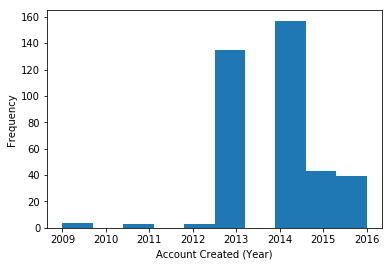

In [17]:
#convert created_at column to datetime objects and plot a histogram of creation years
users['created_at'] = pd.to_datetime(users['created_at'])
years = users['created_at'].dt.year
years.plot(kind='hist')
plt.xlabel('Account Created (Year)')
plt.show()

Interestingly the majority of the accounts were created in 2013 and 2014. When were the popular accounts created relative to the unpopular accounts?

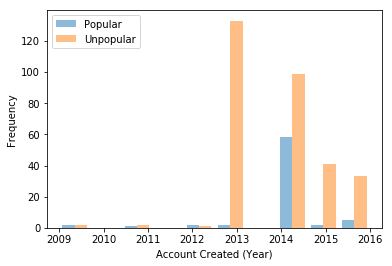

In [18]:
#Convert created_at to datetime and plot histograms of creation years for popular and unpopular users
popular['created_at'] = pd.to_datetime(popular['created_at'])
pop_years = popular['created_at'].dt.year
unpopular['created_at'] = pd.to_datetime(unpopular['created_at'])
unpop_years = unpopular['created_at'].dt.year
plt.hist([pop_years,unpop_years], alpha=0.5,label = ['Popular','Unpopular'])
plt.xlabel('Account Created (Year)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

Interestingly, it looks like nearly all of the popular accounts were created in 2014, were they created at the same time in 2014?

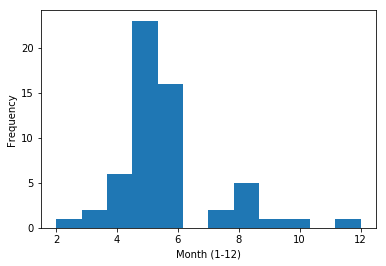

In [19]:
#Plot histogram of creation date by month in the year 2014
pop_year = popular[popular['created_at'].dt.year == 2014]
plt.hist(pop_year['created_at'].dt.month,bins=12)
plt.xlabel('Month (1-12)')
plt.ylabel('Frequency')
plt.show()

Most of the popular accounts were created in May and June of 2014.

When were the unpopular accounts created?

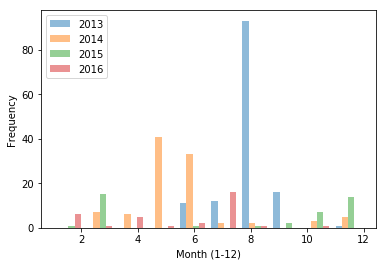

In [20]:
#Plot histograms of creation dates by month over the years 2013-2016 for unpopular accounts
months_list = []
yr_list = [2013,2014,2015,2016]
for el in yr_list:
    df = unpopular[unpopular['created_at'].dt.year == el]
    months = df['created_at'].dt.month
    months_list.append(months)

plt.hist(months_list,alpha = 0.5, label = ['2013','2014','2015','2016'])
plt.xlabel('Month (1-12)')
plt.ylabel('Frequency')
plt.legend(loc='upper left')         
plt.show()

For the 'unpopular' accounts, there is a spike of account creation in August of 2013, and another spike of account creation in May and June of 2014, as was seen for the popular accounts.

# Now that we have a better understanding of the timeline and influence of the accounts in the twitter dataset, let's take a closer look at the tweets themselves

In [21]:
#create a dictionary to replace 'user_key' values in tweets df with 'screen_name' values
users['lower'] = users['screen_name'].str.lower()
s_name = users.screen_name.values
lower = users.lower.values
conversion = dict(zip(lower,s_name))

In [22]:
#replace 'user_keys' with 'screen_names' in tweets dataframe
tweets['user_key'].replace(conversion,inplace=True)
tweets.head()

,user_id,user_key,created_at,created_str,text,tweet_id,hashtags
0,1.868981e+09,RyanMaxwell_1,1.458672e+12,2016-03-22 18:31:42,#IslamKills Are you trying to say that there w...,7.123460e+17,"[""IslamKills""]"
1,2.571870e+09,DetroitDailyNew,1.476133e+12,2016-10-10 20:57:00,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,[]
2,1.710805e+09,CooknCooks,1.487767e+12,2017-02-22 12:43:43,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,[]
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,RT @jww372: I don't have to guess your religio...,8.134006e+17,"[""ChristmasAftermath""]"
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,[]


Let's now look to see the tweets are original content or if they are retweets. Skimming the first few rows, it appears as though many of them are retweets. Let's take a closer look to see what fraction of the collected tweets were retweets.

In [23]:
#create a new True/False column indicating whether the tweet is a retweet
tweets['is_retweet'] = tweets['text'].str.contains('RT @')
tweets['is_retweet'].mean()

0.725618177439411

Almost 73% of the tweets are retweets. Who are the accounts that are getting retweeted? Are they Russian users or 'Real' users?

In [24]:
#create a new row in tweets containing the screen_name of the user who is being retweeted if applicable
tweets['RT_source'] = tweets['text'].str.extract(r'@(\S+):')
tweets['RT_source'].fillna('None',inplace=True)
                      
tweets['RT_source'].head()

0         None
1         None
2      ltapoll
3       jww372
4    Shareblue
Name: RT_source, dtype: object

In [25]:
#create a list of the unique screen_names
user_list = tweets['user_key'].unique()

#Define a function to test whether a value is part of the user_list (for apply function below)
def test_in(el):
    return (el in user_list)

#create a new column in tweets indicating whether the source of a retweeted tweet was in our list of Russian screen_names
tweets['RT_from_user_list'] = tweets['RT_source'].apply(test_in)
#find fraction of all tweets that were retweeting tweets from a Russian troll
tweets['RT_from_user_list'].mean()

0.021323753452393825

Only about 2% of the retweeted tweets were originally composed by a Russian troll. In other words, a very small fraction of the retweets were amplifying an original idea composed by a Russian troll. How many of the retweets were attributable to a user retweeting him/herself?

In [26]:
#Create a new column in tweets indicating T/F of whether a RT was originally composed by the same user
tweets['RT_self'] = tweets['user_key'] == tweets['RT_source']
tweets['RT_self'].mean()

0.0016463372681613116

Only 0.1% of tweets were a user retweeting him or herself.

Let's look to see which users from within the list of Russian trolls were most commonly retweeted

In [27]:
tweets.loc[tweets['RT_from_user_list'] == True, 'RT_source'].value_counts().head(10)
top_retweeted = tweets.loc[tweets['RT_from_user_list'] == True, 'RT_source'].value_counts().head(10).index
print(top_retweeted)

Index(['TEN_GOP', 'ChrixMorgan', 'DanaGeezus', 'GiselleEvns', 'TheFoundingSon',
       'Jenn_Abrams', 'DominicValent', 'gloed_up', 'ScreamyMonkey',
       'tpartynews'],
      dtype='object')


The above users were retweeted more frequently than other users. Was their content original?

In [28]:
top_retweeted = tweets.loc[tweets['RT_from_user_list'] == True, 'RT_source'].value_counts().head(20).index
frac_RT = []
for user in top_retweeted:
    is_rt = round(tweets.loc[tweets['user_key'] == user,'is_retweet'].mean(),2)
    frac_RT.append(is_rt)
    per_rt = is_rt *100
    print('{}% of {}\'s tweets were retweets'.format(per_rt,user))
print(frac_RT)    

3.0% of TEN_GOP's tweets were retweets
33.0% of ChrixMorgan's tweets were retweets
23.0% of DanaGeezus's tweets were retweets
82.0% of GiselleEvns's tweets were retweets
7.000000000000001% of TheFoundingSon's tweets were retweets
1.0% of Jenn_Abrams's tweets were retweets
40.0% of DominicValent's tweets were retweets
44.0% of gloed_up's tweets were retweets
0.0% of ScreamyMonkey's tweets were retweets
15.0% of tpartynews's tweets were retweets
0.0% of SpecialAffair's tweets were retweets
3.0% of Pamela_Moore13's tweets were retweets
82.0% of WorldOfHashtags's tweets were retweets
0.0% of TodayPittsburgh's tweets were retweets
1.0% of Crystal1Johnson's tweets were retweets
0.0% of Politweecs's tweets were retweets
0.0% of TodayCleveland's tweets were retweets
0.0% of Baltimore0nline's tweets were retweets
0.0% of Seattle_Post's tweets were retweets
57.99999999999999% of IlikeBIGbuttand's tweets were retweets
[0.03, 0.33, 0.23, 0.82, 0.07, 0.01, 0.4, 0.44, 0.0, 0.15, 0.0, 0.03, 0.82, 0.0

Who are the users who were most frequently retweeted outside of the Russian troll list?

In [29]:
tweets.loc[tweets['RT_from_user_list'] == False,'RT_source'].value_counts().head(10)

None               55419
blicqer             2207
Conservatexian      1082
realDonaldTrump      593
nine_oh              500
PrisonPlanet         462
ZaibatsuNews         451
gerfingerpoken       434
BIZPACReview         401
beforeitsnews        399
Name: RT_source, dtype: int64

It is an interesting array of users who are getting retweeted: 
blicqer, which has the tag line on twitter: The latest Tweets from blicqer™ (@blicqer). Black News...And More!. Harlem, NY #Unfiltered #Followback.
conservatexian -> Overeducated conservative cowboy. Thinker, Sailor, Soldier, Spy©. Retired/disabled Paratrooper; Professor; Coastie; Private Detective. I don't suffer fools well
...and Donald Trump.

Are the most commonly retweeted russian users also the most prolific?

In [30]:
tweets['user_key'].value_counts().head(10)

AmelieBaldwin     9269
hyddrox           6813
GiselleEvns       6652
PatriotBlake      4140
TheFoundingSon    3663
MelvinSRoberts    3346
mrclydepratt      3263
brianaregland     3261
LeroyLovesUSA     3229
BaoBaeHam         3215
Name: user_key, dtype: int64

Apparently not - only GiselleEvns. This suggests that the likelihood of a Russian user retweeting another Russian user was not simply due to chance, otherwise the most prolific Russian tweeters would also be the most retweeted. This points to the possibility that there may be some structure in who is retweeting whom.

In [31]:
top_tweeter = tweets['user_key'].value_counts().head(20).index
top_frac_RT = []
for user in top_tweeter:
    is_rt = round(tweets.loc[tweets['user_key'] == user,'is_retweet'].mean(),2)
    top_frac_RT.append(is_rt)
    per_rt = is_rt *100
    print('{}% of {}\'s tweets were retweets'.format(per_rt,user))
print(top_frac_RT) 

100.0% of AmelieBaldwin's tweets were retweets
100.0% of hyddrox's tweets were retweets
82.0% of GiselleEvns's tweets were retweets
99.0% of PatriotBlake's tweets were retweets
7.000000000000001% of TheFoundingSon's tweets were retweets
73.0% of MelvinSRoberts's tweets were retweets
100.0% of mrclydepratt's tweets were retweets
100.0% of brianaregland's tweets were retweets
86.0% of LeroyLovesUSA's tweets were retweets
100.0% of BaoBaeHam's tweets were retweets
96.0% of melanymelanin's tweets were retweets
90.0% of LauraBaeley's tweets were retweets
85.0% of JeffreyKahunas's tweets were retweets
100.0% of DatWiseNigga's tweets were retweets
3.0% of TEN_GOP's tweets were retweets
91.0% of EmileeWaren's tweets were retweets
90.0% of GarrettSimpson_'s tweets were retweets
93.0% of JacquelinIsBest's tweets were retweets
90.0% of _NickLuna_'s tweets were retweets
85.0% of MichelleArry's tweets were retweets
[1.0, 1.0, 0.82, 0.99, 0.07, 0.73, 1.0, 1.0, 0.86, 1.0, 0.96, 0.9, 0.85, 1.0, 0.03, 

There is a substantial difference between the most prolific tweeters and the most frequently retweeted users in terms of the amount of original content. The most retweeted users have more original content, whereas the most prolific tweeters are almost exclusively retweeting other users.

## Next, let's try to study the hourly distribution of tweets over a 24 hour period

## We will look at the distribution of tweets for all users, the top 20 Russian tweeters and the top twenty retweeted Russian users

In [32]:
#Create a simplified df containing only 'user_key','created_str','RT_source' and dropna rows
simple = tweets.iloc[:,[1,3,8]].dropna().copy()
#convert 'created_str' to datetime object
simple['created_str'] = pd.to_datetime(simple['created_str'])
#collect hour attribute in a new column
simple['hour'] = simple['created_str'].dt.hour.astype(float)
#print(simple.head())


#Function that accepts a list of users and the 'user_key' or 'source' column names as input
#Generates a count of a users tweets for each hour of the day
#Returns a dictionary mapping a 'user_key' or a 'source' to a list containing the hourly tweet count
def hour_hist(user_list,column,RT_col = False):
    time_dict = {}
    for user in user_list:
        #print(user)
        if user in simple[column].tolist():
            #print(user)
            time_list = simple.loc[simple[column]==user,'hour'].tolist()
            #print(time_list)
            count_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
            for el in time_list:
                int_el = int(el)
                count_list[int_el] += 1
            #print(count_list)    
            sum_count = sum(count_list)
            #print(sum_count)
            new_list = [el/sum_count for el in count_list]
            if RT_col == True:
                rt_frac = round(tweets.loc[tweets['user_key'] == user,'is_retweet'].mean(),2)
                new_list.append(rt_frac)
                time_dict[user] = new_list
                data_frame = pd.DataFrame.from_dict(time_dict,orient='index')
                data_frame.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,'RT']
            else:
                time_dict[user] = new_list
                data_frame = pd.DataFrame.from_dict(time_dict,orient='index')
                #print(data_frame.head())
                data_frame.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]
    return data_frame 


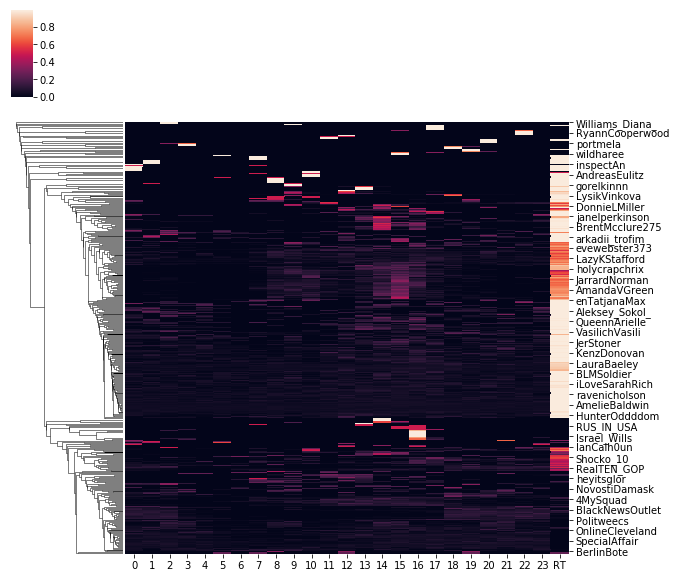

In [33]:
#Tweet pattern all tweets
all_users = tweets['user_key'].unique().tolist()
#print(all_users)
#all_user_dict = hour_hist(all_users, 'user_key')
all_heat = hour_hist(all_users,'user_key',RT_col=True)
   
sns.clustermap(all_heat,metric='minkowski',col_cluster=False,robust=True)

From this we can see that there is great variety in the typical tweeting pattern over a 24 hour period among the users. Some users tweet selectively in a small window each day (top rows), some users tweet consistently over the 24 hour period.

From the RT column on the right, we can see that ~2 out of 3 users has a high proportion of tweets that are retweets (over 60%). Is there a noticeably different pattern of tweeting if we focus on the users who are primarily tweeting original content? 

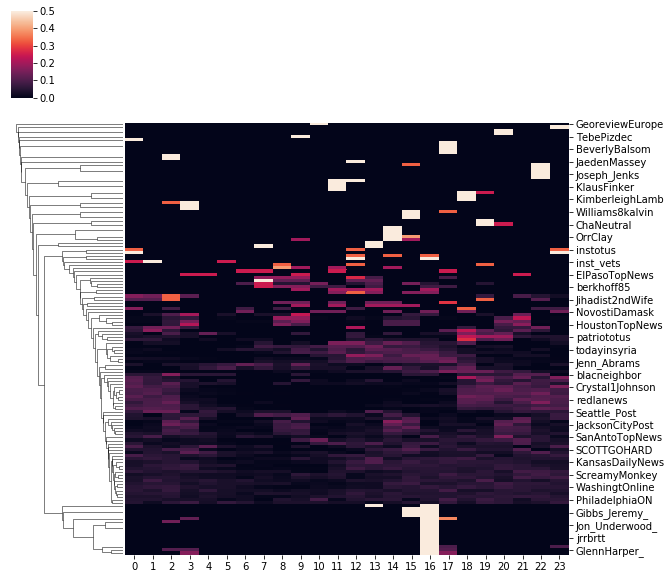

In [34]:

#Tweet pattern for users with >90% original tweets
originals = all_heat.loc[all_heat['RT'] < 0.1].index
#Create heatmap dataframe
original_heat = hour_hist(originals,'user_key')
#display clustermap   
sns.clustermap(original_heat,metric='minkowski',col_cluster=False,robust=True)

Qualitatively, it appears as though the users posting original content have a greater tweet time preference (i.e. more users have a typical tweet time)

What is the tweeting pattern over a 24 hour period for the top 20 tweeters?

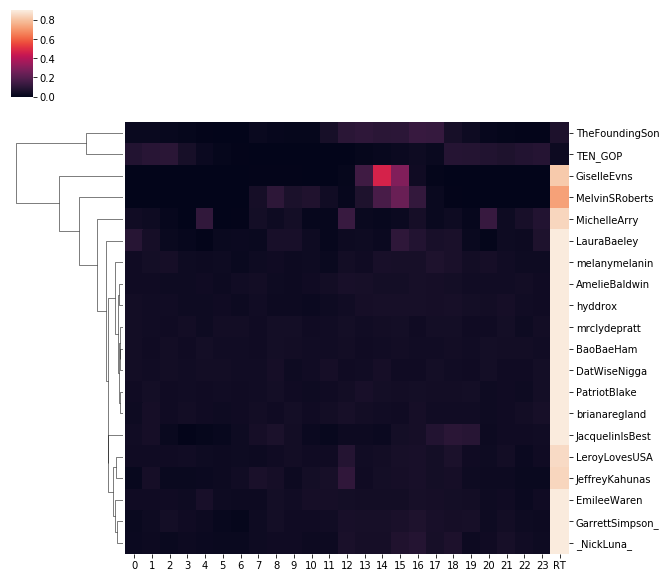

In [35]:
#create a list of the top 20 tweeters in the tweets dataset
top_twenty = simple['user_key'].value_counts().head(20).index
#create heatmap dataframe.
twenty_time_heat = hour_hist(top_twenty, 'user_key',RT_col=True)
#Plot a clustered heatmap to show tweeting patterns over a 24 hour period for the top 20 tweeters
sns.clustermap(twenty_time_heat,metric='minkowski',col_cluster=False,robust=True)


With the exception of the top 4 rows, this plot shows that there is no real time preference in the tweets for the most prolific tweeters. We can also see (as we had seen previously) that most of the content 

What is the tweeting pattern over a 24 hour period for the top 20 most retweeted users?

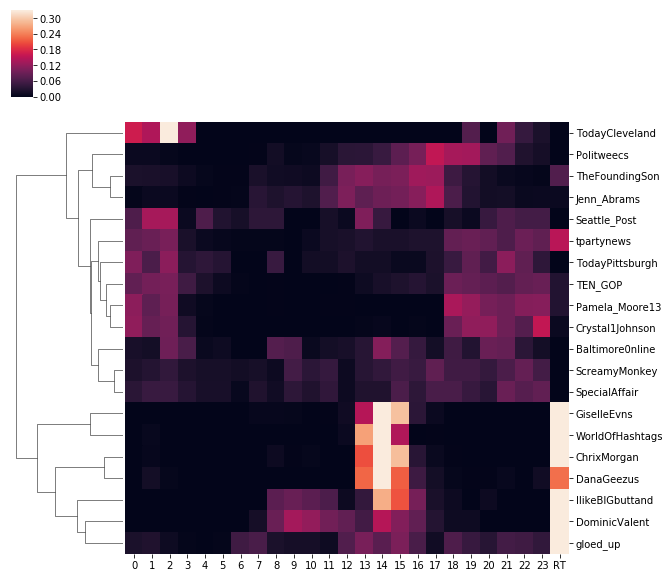

In [36]:
#Tweet pattern of top 20 most retweeted users
retweet_top_twenty = tweets.loc[tweets['RT_from_user_list'] == True, 'RT_source'].value_counts().head(20).index
#Create heatmap dataframe
RT_heat = hour_hist(retweet_top_twenty,'user_key',RT_col=True)
#Plot clustered heatmap
sns.clustermap(RT_heat,metric='minkowski',col_cluster=False,robust=True)

By comparing distribution of tweets over a 24 hour period for the top 20 tweeters with that of the 20 most-retweeted users, we can see that there is a bit more order in the users who are retweeted (i.e. there is a typical tweeting schedule)

There are clearly different tweeting patterns. For example, WorldOfHashtags, DanaGeezus, ChrixMorgan, and GiselleEvns have a similar schedule (one burst around 1-3PM), while Pamela_Moore13, Crystal1Johnson, TodayPittsburgh, TEN_GOP, and tpartynews have a different schedule (more steady tweets between 6PM-2AM)

Tweet pattern also appears to correlate with tweet content. Those users who have a single burst of tweets mid-day are more likely to retweet other users' content (See RT column in the bottom plot, which indicates proportion of tweets that are retweets)

## Is there any apparent preference in the time for retweeting users outside of the user set?

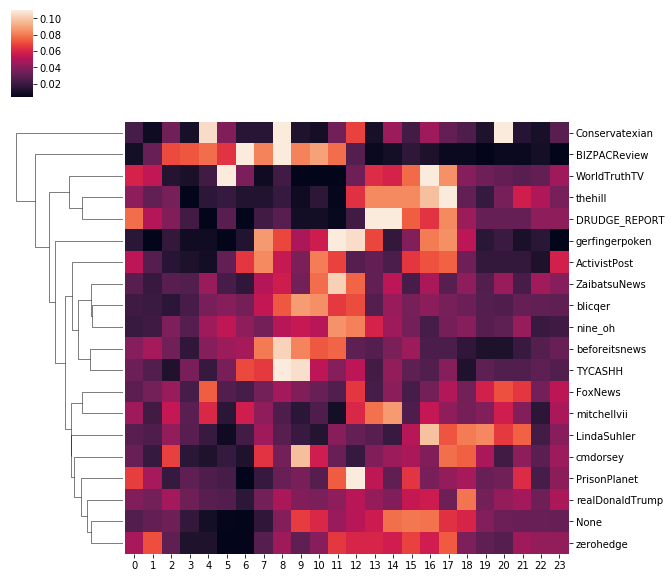

In [37]:
#Pattern of tweets that are retweeting the most commonly retweeted users OUTSIDE of Russian user set
out_rt_top_twenty = tweets.loc[tweets['RT_from_user_list'] == False, 'RT_source'].value_counts().head(20).index

#Create heatmap dataframe, RT column is omitted because it obscures tweet pattern data
out_rt_heat = hour_hist(out_rt_top_twenty,'RT_source')
#Show clustermap
sns.clustermap(out_rt_heat,metric='minkowski',col_cluster=False,robust=True)

From the `user_key`s of the most retweeted users, it appears as though many of them were marketing themselves as news outlets. Is there any pattern in the tweets for these users?

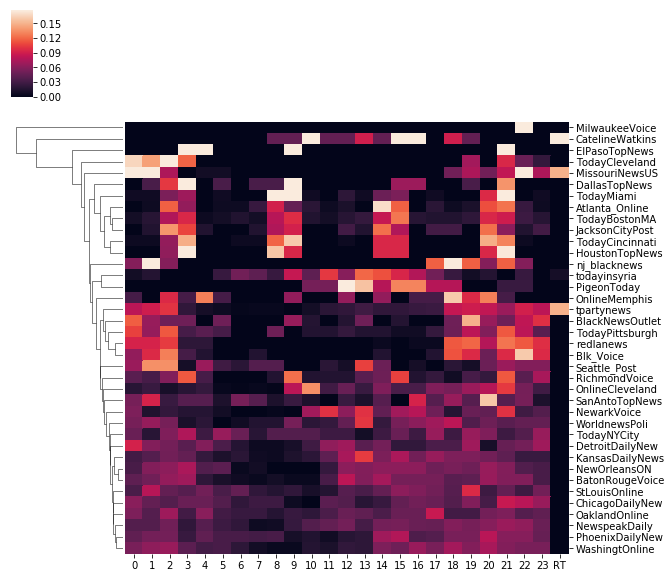

In [38]:
#What is the tweet time distribution for users pretending to be news outlets?

#List of words commonly associated with news outlets
news_word_list = ['today','post','online','new','voice']
joined_news = '|'.join(news_word_list)
#lower case all users
lower_users = tweets['user_key'].str.lower()
#create array of unique 'news' users
news_users = tweets.loc[lower_users.str.contains(joined_news),'user_key'].unique()
#Create heatmap dataframe 
news_heat = hour_hist(news_users,'user_key',RT_col=True) 
#display clustermap                       
sns.clustermap(news_heat,metric='minkowski',col_cluster=False,robust=True)


There are some clear patterns for the tweets of those users who market themselves as news sites. A number of users have a wave-like pattern, while other users work at night (this may be a time-zone difference), and other users work more consistently, with a common gap between 3AM-11AM.

From looking at these tweet patterns over a 24 hour period, and thinking about the most resource efficient way of amplifying messages on twitter, I would hypothesize that:

1) There are a limited number of real humans generating original content, and these users would likely follow a tweeting schedule similar to that of the "news" outlets above and some of the most retweeted users above - natural peaks and troughs, with a 5-10 hour downtime.

2) There are vastly more bots, who are amplifying the content of other Russian users and outside users who express views consistent with the goals of those hoping to influence the election. These users are likely to have a more "unnatural" tweeting schedule (e.g. tweeting at a very specific time of day almost exclusively, or tweeting all the time, with no downtime). 

3) There are layers of amplification: A) an original tweet is probably retweeted by B) a select few users, who are very active, aggregating and capturing content to be retweeted by a much larger population (e.g. GiselleEvns, one of the most prolific tweeters and retweeters), and C) The less active, but large number of users who amplify and spread the content to their respective friends and followers. 

## Let's try to study the linkage between users in more detail

The analysis above is based on a lot of inference and a qualitative examination of the typical tweet times. Let's try to look at how specific tweets are retweeted through the Russian user population. To do this, we have to clean up the text to remove mentions and hashtags, as these may be added to the text of a tweet by a retweeter. We want to look for the core text.

In [39]:
#Copy tweets dataframe, removing rows that have na values for text
new_tweets = tweets.loc[tweets['text'].notna()].copy() 
#Remove the RT @xyz: part of a tweet by splitting text at : that is NOT preceded by https
split = new_tweets['text'].str.split(r'(?<!https):',n=1,expand=True)
#Take the column containing the RT-free text, fill Na values with the left column for those tweets that were not retweets
split[1].fillna(split[0],inplace=True)
#Add this new 'clean_text' column to the new_tweets data frame
new_tweets['clean_text'] = split[1]
#Clean up the 'clean_text' column further, by removing hashtags, mentions, #, @, and other various symbols
new_tweets['clean_text'] = (new_tweets['clean_text']
                                .str.replace('7yrs','')
                                #remove hashtags
                                .str.replace(r'(?<=#)[A-Za-z0-9]+','')
                                #remove mentions
                                .str.replace(r'(?<=@)[A-Za-z0-9]+','')
                                #.str.lstrip('#')
                                .str.strip('[# ]+')
                                .str.strip('[@ ]+')
                                .str.strip(')')
                                .str.strip('(')
                                .str.strip('lol')
                                .str.strip('"')
                                .str.strip(u'\u2026')
                                .str.strip('#')
                                .str.lstrip(':')
                                .str.strip(' ')
                            
                           )
new_tweets.head()

,user_id,user_key,created_at,created_str,text,tweet_id,hashtags,is_retweet,RT_source,RT_from_user_list,RT_self,clean_text
0,1.868981e+09,RyanMaxwell_1,1.458672e+12,2016-03-22 18:31:42,#IslamKills Are you trying to say that there w...,7.123460e+17,"[""IslamKills""]",False,None,False,False,Are you trying to say that there were no terro...
1,2.571870e+09,DetroitDailyNew,1.476133e+12,2016-10-10 20:57:00,"Clinton: Trump should’ve apologized more, atta...",7.855849e+17,[],False,None,False,False,"Trump should’ve apologized more, attacked less..."
2,1.710805e+09,CooknCooks,1.487767e+12,2017-02-22 12:43:43,RT @ltapoll: Who was/is the best president of ...,8.343832e+17,[],True,ltapoll,False,False,Who was/is the best president of the past 25 y...
3,2.584153e+09,queenofthewo,1.482765e+12,2016-12-26 15:06:41,RT @jww372: I don't have to guess your religio...,8.134006e+17,"[""ChristmasAftermath""]",True,jww372,False,False,I don't have to guess your religion!
4,1.768260e+09,mrclydepratt,1.501987e+12,2017-08-06 02:36:24,RT @Shareblue: Pence and his lawyers decided w...,8.940243e+17,[],True,Shareblue,False,False,Pence and his lawyers decided which of his off...


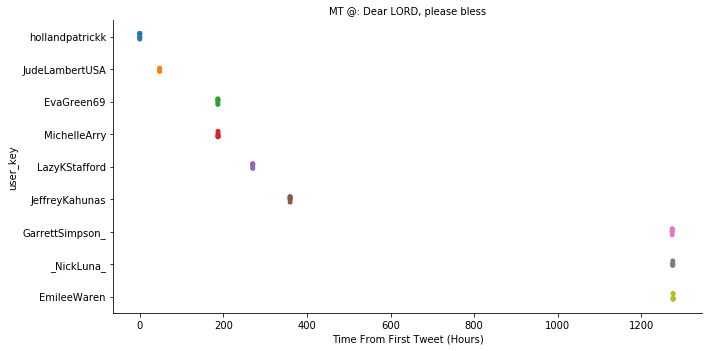

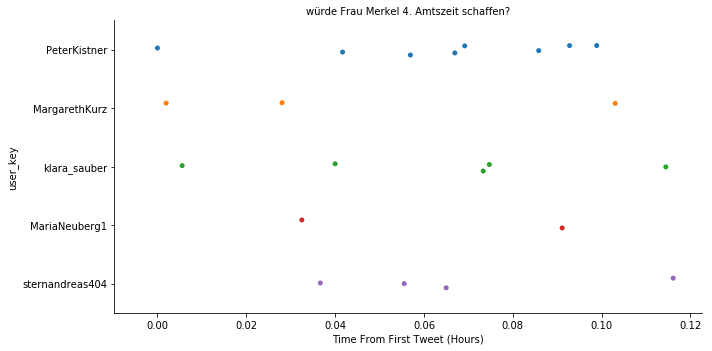

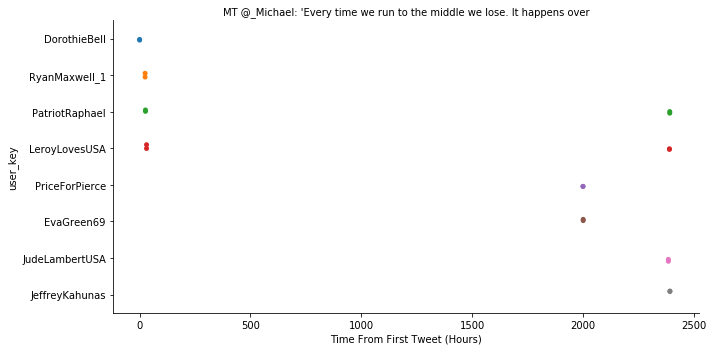

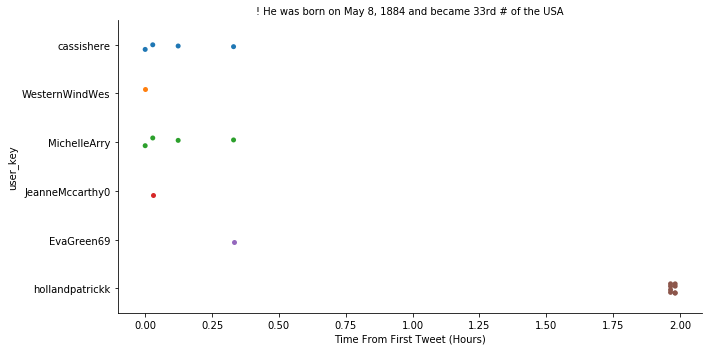

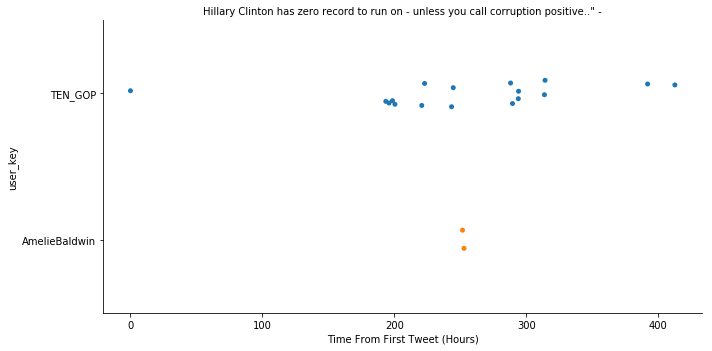

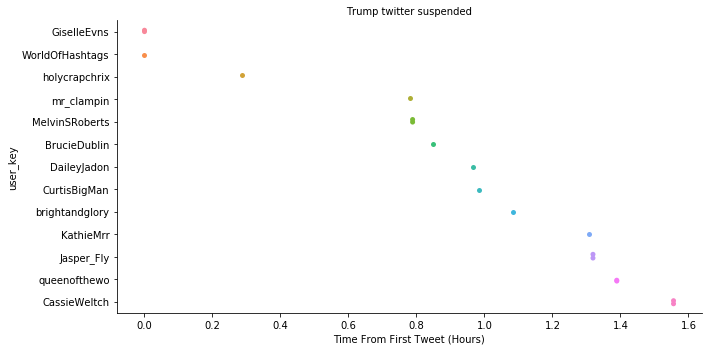

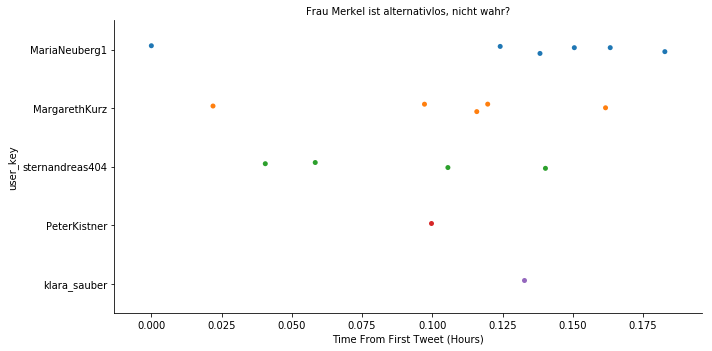

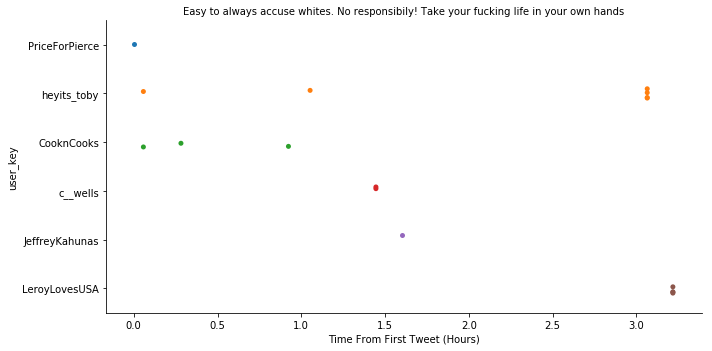

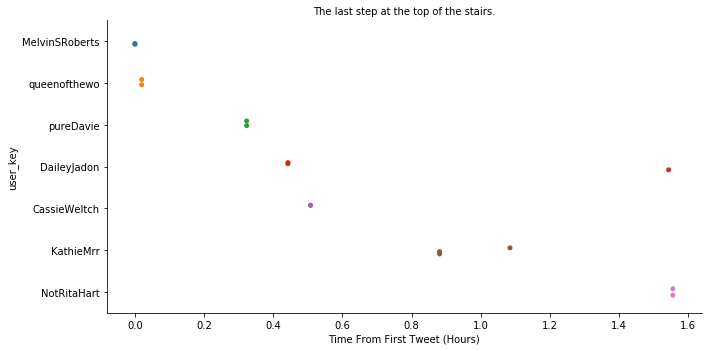

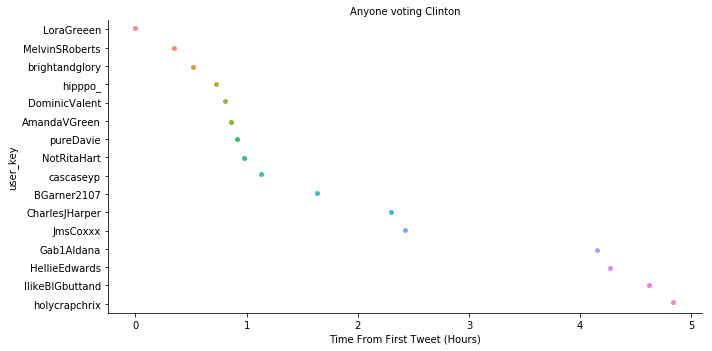

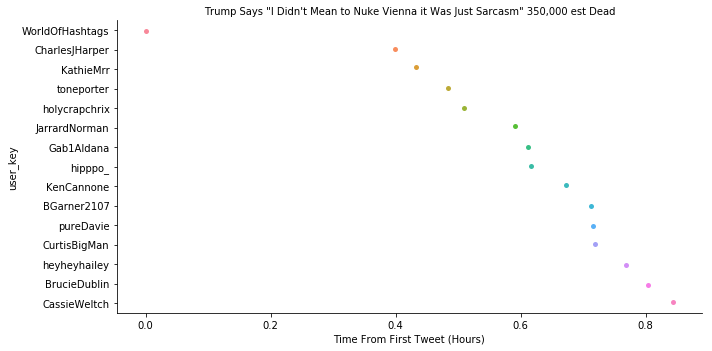

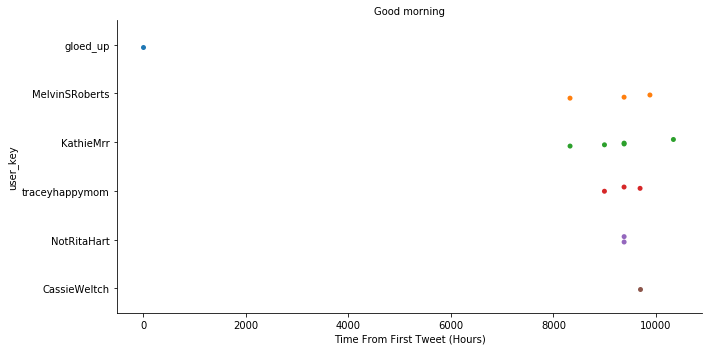

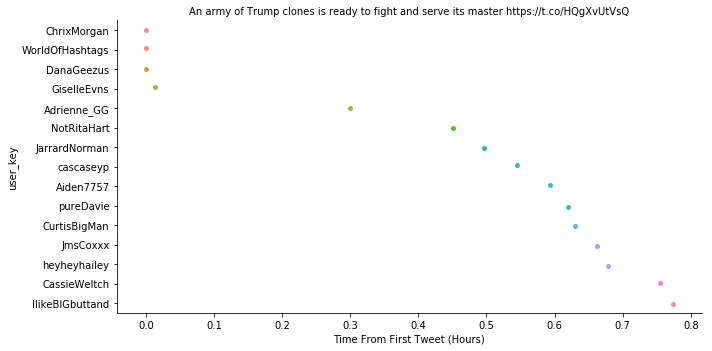

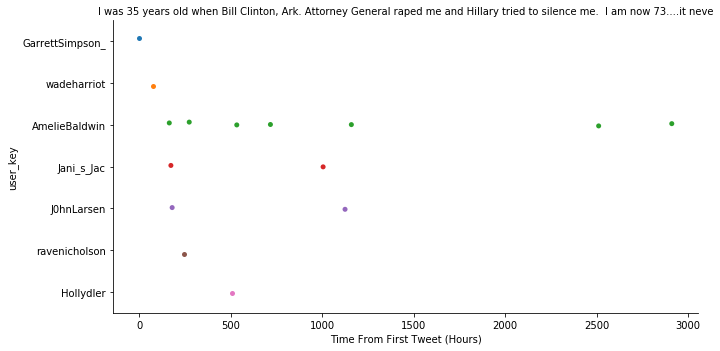

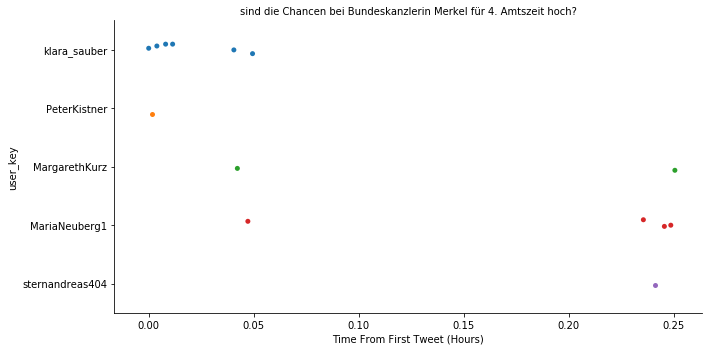

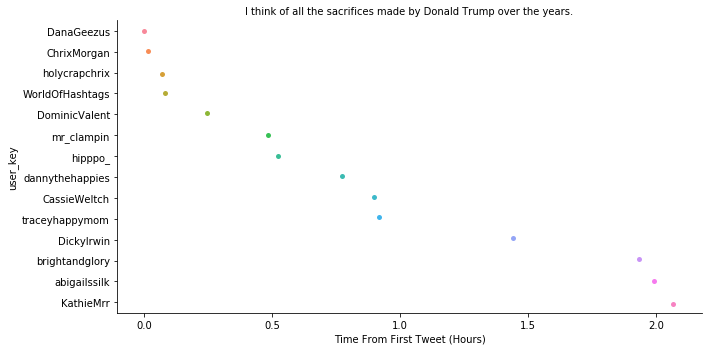

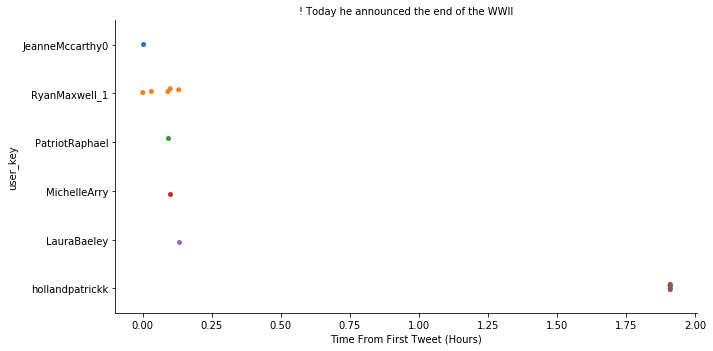

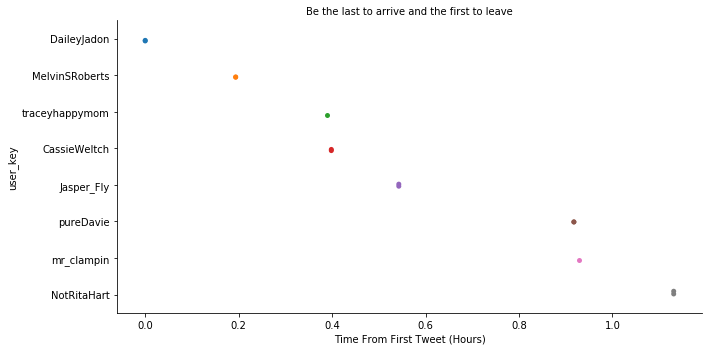

In [40]:
#Create a list of strings containing the 200 most retweeted 'core' tweets
string_list = new_tweets['clean_text'].value_counts(dropna=True).head(200).index

def time_diff(df):
    #This function takes a dataframe as input, which should be structured like the new_tweets df
    #creates a subsetted df with a selection of the columns, converts tweet time to datetime, subtracts
    #datetime object from the original tweet time, and returns a dataframe with a new column 'time_diff'
    #with the time difference from the original tweet presented in hours. This is a helper function for time_df_list (below)
    
    s_df = df.iloc[:,[1,3,4,7,8,9,10,11]].copy()
    s_df['created_str'] = pd.to_datetime(s_df['created_str'])
    s_df.sort_values(by='created_str',ascending=True,inplace=True)
    #initialize a list of time differences; the first element is the first tweet minus itself, so 0
    time_diff_list = [0]
    #subtract the time of each tweet from the time of the first tweet
    for i in range (1, len(s_df['created_str'])):
        time_diff = s_df.iloc[i,1] - s_df.iloc[0,1]
        #represent time differences in hours 
        time_diff_list.append(time_diff.total_seconds()/3600)
    #add a column to the subsetted data frame with the time difference values
    s_df['time_diff'] = time_diff_list
    #sort time_diff column
    s_df.sort_values(by='time_diff',ascending=True, inplace=True)
    return s_df
    
def time_df_list(tweet_list,chain_plots=False):
    #initialize a list to contain dataframes for each tweet
    df_list = []
    #iterate over 'core' tweet list
    for el in tweet_list:
        #subset dataframe to include only tweets with a given 'clean_text'
        df = new_tweets[new_tweets['clean_text'] == el]
        if chain_plots == False:
            #size variable counts the number of times this text has been retweeted
            size = df.shape[0]
            #If the text is not an empty string, and it has been retweeted more than 10 times, create a small
            #dataframe with select columns, convert the 'created_str' column to datetimes, and sort from first to last
            if (el != '') & (size > 10):
                s_df = time_diff(df)
                #append sorted data frame to list of dataframes
                df_list.append(s_df)
        else:
            #this definition of size selects for those retweet patterns where there is a chain of single retweets
            size = df.shape[0] / len(df['user_key'].unique())
            if (el != '') & (size < 2):
                s_df = time_diff(df)
                #append sorted data frame to list of dataframes
                df_list.append(s_df)
    return df_list

text_df_list = time_df_list(string_list[:20])

#plot catplots one at a time (this was the cleanest way I found to do this, otherwise there were issues with facets in the figure)
for i in range(0,len(text_df_list)-1):
    p = sns.catplot(data=text_df_list[i],x='time_diff',y='user_key',col='clean_text',aspect=2)
    p.set_titles('{col_name}')
    p.set_xlabels('Time From First Tweet (Hours)')
    


From this sample of plots, we can see what appears to be two tweeting patterns:
1) A few users retweeting each other or themselves many times in parallel
2) Chains of retweets in which one user is retweeted by a different user, who in turn is retweeted by a different user.
There is also a significant range in the time between retweets for a given tweet, from 20 tweets in ~ 1 min, to a similar number over the course of about a year.

Interestingly the chains of retweets (option 2, above) typically occur in a smaller timeframe 20 min-
5hrs. 

Let's take a closer look at those chains of retweets to see if certain users typically come before other users in the sequence.

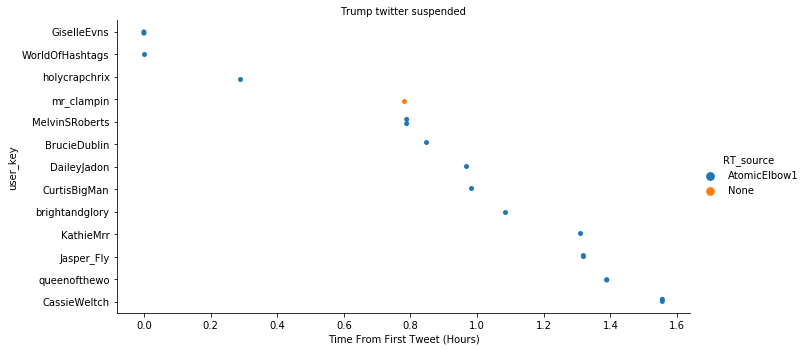

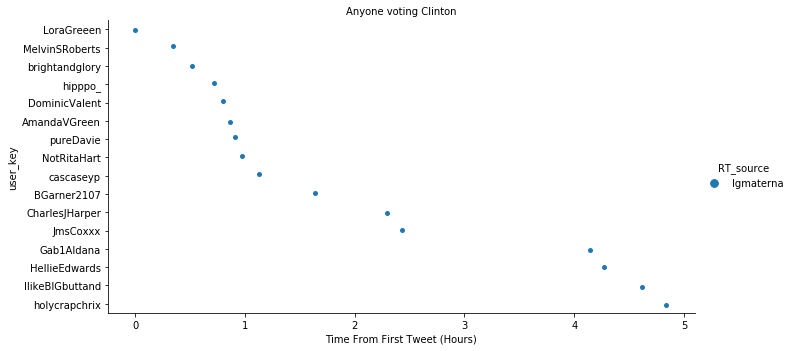

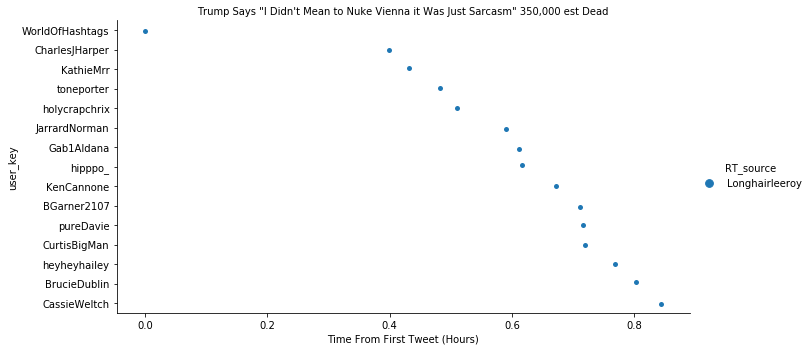

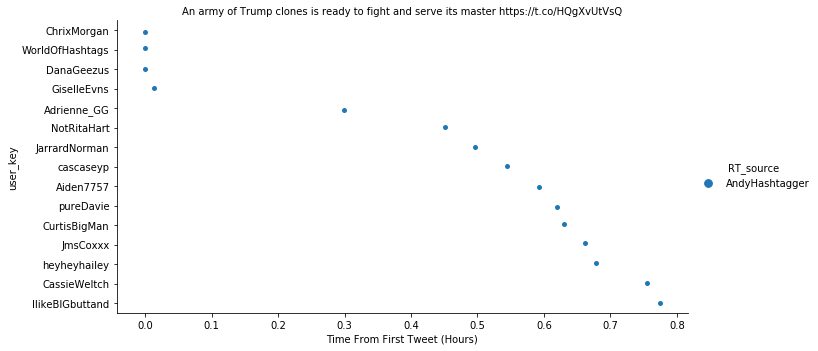

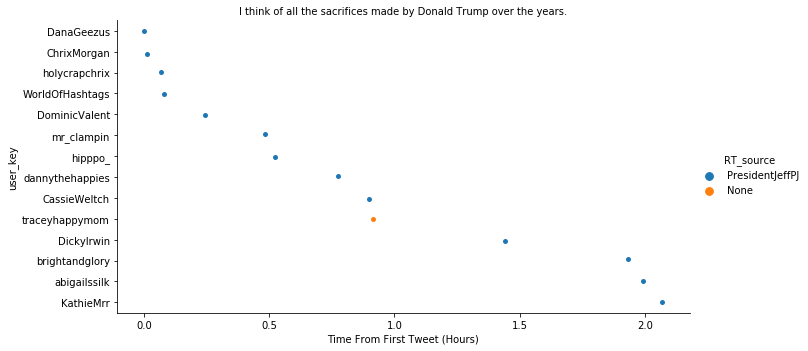

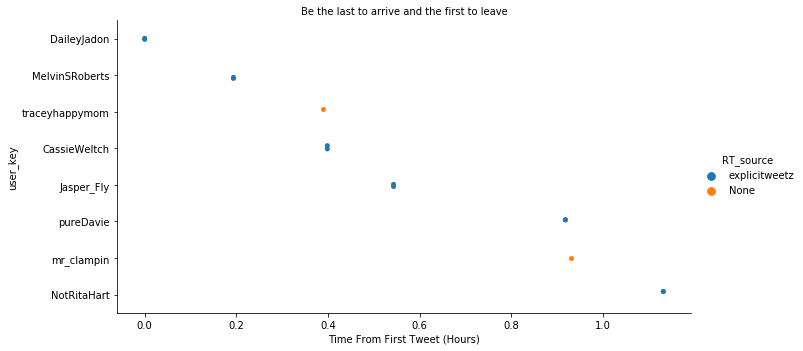

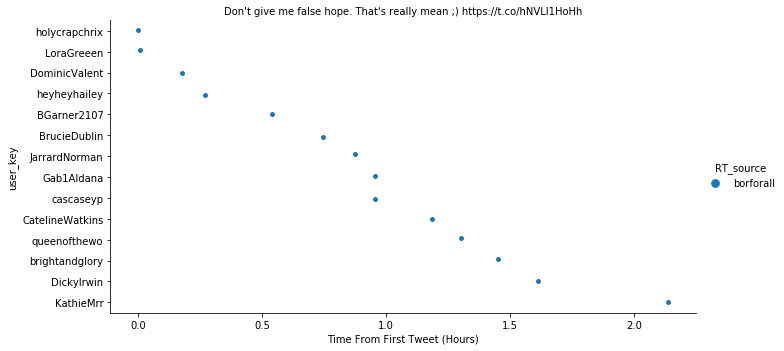

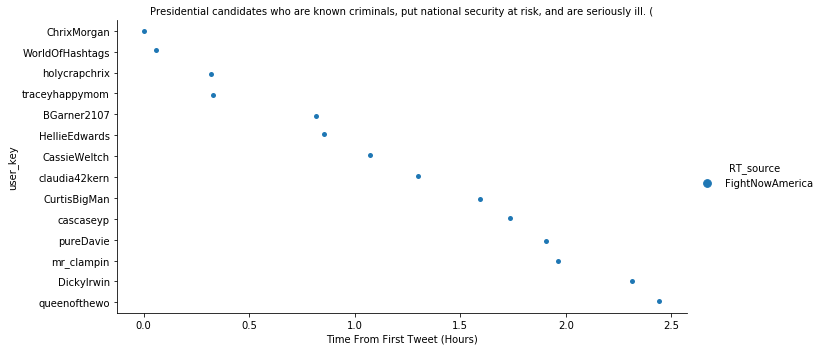

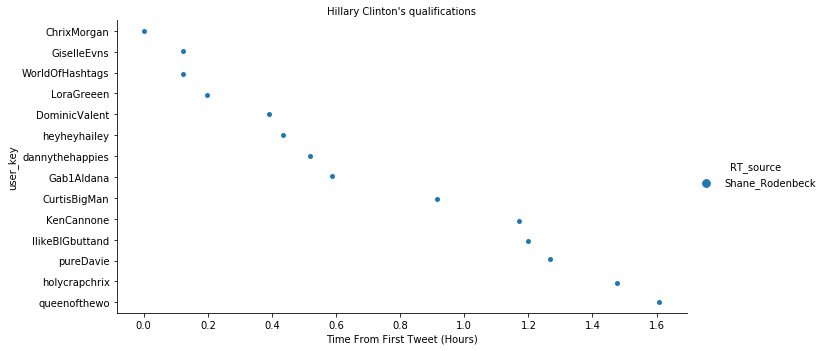

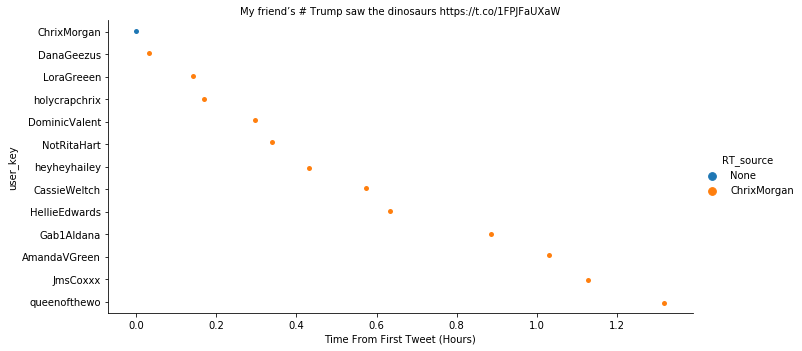

In [41]:
#create dataframe list for chain retweets
chain_df_list = time_df_list(string_list,chain_plots=True)
#plot chains
for i in range(0,10):
    p = sns.catplot(data=chain_df_list[i],x='time_diff',y='user_key',col='clean_text',hue='RT_source',aspect=2)
    p.set_titles('{col_name}')
    p.set_xlabels('Time From First Tweet (Hours)')


One notable feature of these chains is that they are typically all retweeting the same original user, so it is not so much a chain of tweets as a ripple from a single source propagating outward.

In [42]:
#Create a list of the top 40 users retweeting other Russian users
in_rt_top_forty = tweets.loc[tweets['RT_from_user_list'] == True, 'user_key'].value_counts().head(40).index

#This effectively creates a heatmap of a user's typical position in the retweet chain
user_position_dict = {}
for user in in_rt_top_forty:
    #print(user)
    position_dict = {}
    #iterate through chain tweet dataframes
    for i in range(0,len(chain_df_list)):
        now_df = chain_df_list[i].copy()
        #reset index to be able to access index as integers
        now_df.reset_index(inplace=True)
        #test if user is in the 'user_key' column of people who retweeted a given tweet
        if user in now_df['user_key'].tolist():
            #capture the position of that user in the sequence of retweets as a list (sometimes a person tweets twice)
            positions = now_df.index[now_df['user_key']==user].tolist()
            #Pick the first occasion that the person tweeted (if multiple tweets)
            first_position = positions[0]
            #Count the number of times that person tweets at a given position in the sequence of retweets
            if first_position in position_dict:
                position_dict[first_position] += 1
            else:
                position_dict[first_position] = 1
        
        else:
            pass
    #map the position_dict to the user_key
    user_position_dict[user] = position_dict
#create a dataframe from the dictionary        
sequence = pd.DataFrame.from_dict(user_position_dict,orient='index')   
#sequence

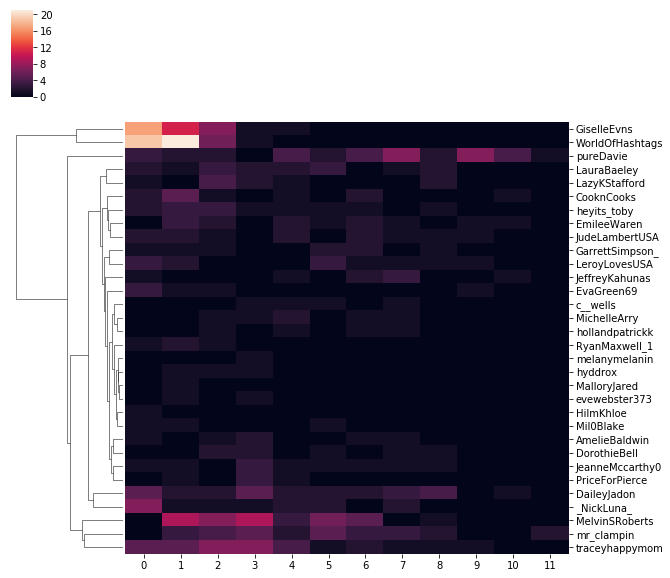

In [43]:
#get columns names
cols = sequence.columns
#sort columns numerically and take only the first 12
cols = sorted(cols)[:12]
#sort columns and create a new dataframe n_sequence
n_sequence = sequence[cols].copy()
#replace na values with 0
n_sequence.fillna(0,inplace=True)
#Display clustermap
sns.clustermap(n_sequence,metric='minkowski',col_cluster=False)

#### Using the top 200 retweeted tweets, with the 40 top retweeters, we can begin to see a pattern where there are a few instigators (WorldOfHashtags, GiselleEvns, traceyhappymom) who are more likely to tweet early on in a sequence, then there are others who more commonly come next (MelvinSRoberts), then DaileyJadon and mr_clampin, then pureDavie. It is probably significant that there is not a single person who typically is the last in the tweeting sequence. This would reflect that 1) the original tweet has been amplified (diluted among the large population of retweeters) and 2) there is no fixed sequence of retweeting. It is also significant that in most cases the three instigators are not the source of the original tweet. They may come early in the sequence more commonly because they are some of the most active users with more followers, and who follow more people.

#### From this analysis we can see a number of interesting aspects of how tweets are retweeted within the Russian user set. 1) There are different patterns ("chain" vs. "burst") 2) most of the retweets are retweeting content that was generated outside of the user list, 3) There are some users who are more likely to initiate retweet chains, possibly reflecting their connectedness to the outside twitter community, and possibly as a way to sample external content, then load it into the twitter retweeting machines to amplify the message among lots of less popular users. This is a good way to popularize messages.

## Now that we have studied these connections on the level of individual tweets, let's explore how users are connected into a network, by first focusing on the top 10 retweeted users and their top 20 retweeters.

In [44]:
edge_list = []
#iterate over the first 10 users in the top_retweeted list
for user in top_retweeted[:10]:
    #initialize a dataframe to consolidate 'edges' - connections between a source and a retweeter
    edge_df = pd.DataFrame()
    #collect all retweets from a given source, and present the 'RT_source' column
    edge_df['source'] = tweets.loc[(tweets['is_retweet']==True) & (tweets['RT_source']==user),'RT_source']
    #collect all retweets from a given source, and present the 'user_key' column
    edge_df['user'] = tweets.loc[(tweets['is_retweet']==True) & (tweets['RT_source']==user),'user_key']
    #create an array of the top twenty users who retweeted the source 
    top_retweeters = edge_df['user'].value_counts().head(20).index
    #Create a list of (source,retweeter) tuples
    top_list = list(zip([user]*len(top_retweeters),top_retweeters))
    for el in top_list:
        #add each edge for each top_retweeted source to the edge_list
        edge_list.append(el)


In [45]:
import networkx as nx
#Create a directional graph object
B = nx.DiGraph()
#Populate the graph with connections in edge_list
B.add_edges_from(edge_list)
#calculate in_degree_centrality for each person in the graph
#this is the number of edges that end at a given user divided by the total number of users
#in this case it reflects how many people a given person retweets
in_deg_dict = nx.in_degree_centrality(B)
#create the 'central' dataframe from the in_deg_dict dictionary
central = pd.DataFrame.from_dict(in_deg_dict,orient='index')
#sort dataframe by in-degree values
central = central.sort_values(by=0,ascending=False)
#assign top 20 retweeters to the top_retweeter variable
top_retweeter = central.head(20).index

print(top_retweeter)

Index(['DorothieBell', 'GiselleEvns', 'heyits_toby', '_NickLuna_', 'pureDavie',
       'MichelleArry', 'MelvinSRoberts', 'EvaGreen69', 'LazyKStafford',
       'traceyhappymom', 'LauraBaeley', 'PriceForPierce', 'AmelieBaldwin',
       'JacquelinIsBest', 'CooknCooks', 'NotRitaHart', 'Mil0Blake',
       'evewebster373', 'JeffreyKahunas', 'hollandpatrickk'],
      dtype='object')


In [46]:
#This code was modified from code found here: https://bokeh.pydata.org/en/latest/docs/user_guide/graph.html
from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool
from bokeh.models.graphs import from_networkx


#top 20 most retweeted users
top_retweeted = tweets.loc[tweets['RT_from_user_list'] == True, 'RT_source'].value_counts().head(20).index
#list of 10 colors for the top 10 most retweeted users
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']
#Create a dict mapping a user to a color
top_rt_map = dict(zip(top_retweeted,colors))

#SET EDGE COLORS
#initialize the edge_attr dictionary
edge_attr = {}
#iterate over edges list for the graph
for start_node,end_node, _ in B.edges(data=True):
    #define color based on the start node (retweeted user) in the user:color dictionary above
    color = top_rt_map[start_node]
    #map the edge to the color selected above
    edge_attr[(start_node, end_node)] = color
#create a new attribute of the edges in B called edge color, using the edge_attr dictionary  
nx.set_edge_attributes(B, edge_attr, "edge_color")

#SET NODE COLOR AND SIZE
#initialize dicts to map a user's node to a color and size
color_map = {}
size_map = {}
#iterate through nodes in the B graph (this is a tuple ('user_key',{}), so we need to access the first element)
for node in B.nodes(data=True):
    #Test if user is in the top 10 retweeted set
    if node[0] in top_rt_map:
        #if yes, assign the color using the dictionary above, and the size = 15
        color_map[node[0]] = top_rt_map[node[0]]
        size_map[node[0]] = 15
    #Test if the user is one of the top 20 retweeters in the top_retweeter list (above)
    elif node[0] in top_retweeter:
        #if so color the user's node black and set size at 8
        color_map[node[0]] = 'black'
        size_map[node[0]] = 8
    #if not either of these things, set users color grey and size 4
    else:
        color_map[node[0]] = 'grey'
        size_map[node[0]] = 4

#create and set node attibutes 'color' and 'size' using the dictionaries created above       
nx.set_node_attributes(B, color_map, 'color')
nx.set_node_attributes(B, size_map,'size')

#Show with Bokeh
#Initialize a plot object with the given size and title
plot = Plot(plot_width=500, plot_height=500,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Linkage Between Top 10 retweeted users and their Top 20 retweeters"
#Initialize this cool node_hover_tool, which allows users to inspect node identity
node_hover_tool = HoverTool(tooltips=[("index", "@index")])
#add the hover_tool, zoomtool, and resettool to the plot
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())

#create a graph renderer using the data in B, applying a circular layout
graph_renderer = from_networkx(B, nx.circular_layout, scale=1, center=(0, 0))
#render the nodes using circles, with the size and color defined according to the node attributes set above
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color='color',fill_alpha=1,line_color='color')
#render the edges with the edge_color defined in the edge attributes
graph_renderer.edge_renderer.glyph = MultiLine(line_color='edge_color', line_alpha=0.8, line_width=1)
#add the rendered data to the plot
plot.renderers.append(graph_renderer)
#display plot in notebook setting
output_notebook()
show(plot)

Loading BokehJS ...

#### From this graph we can see that there are a number of users who play a more important role in retweeting these top 10 retweeted users. These include some of the users identified above who typically fall in the middle of the tweet chains (e.g. MelvinSRoberts is a medium sized black dot, indicating a high in-degree-centrality score). We can also see that there are some users who are only connected with a single source (e.g. lower right of the graph, mr_clampin, Jasper_Fly, etc) are uniquely associated with DominicValent, as are melanymelanin and BleepThePolice uniquely associated with gloed_up.

#### Thus there are users who are frequently used to retweet other russian users, and some that are more specific to a given source.

## Given that most of the tweets in the dataset are retweets from non-Russian users, who is the top source for the top 50 retweeters, and how are they connected? Let's take a look.

In [47]:
#Create array of top 50 retweeters
top_fifty_rt = tweets.loc[tweets['is_retweet'] == True, 'user_key'].value_counts().head(50).index

#Create an edge list mapping each of the top 50 retweeters to their top source, and collect their number of
#retweetes in the size_df_dict
in_edge_list = []
source_list = []
size_df_dict = {}
for user in top_fifty_rt:
    #create data frame mapping sources to retweeters 
    edge_df = pd.DataFrame()
    edge_df['source'] = tweets.loc[(tweets['is_retweet']==True) & (tweets['user_key']==user),'RT_source']
    edge_df['user'] = tweets.loc[(tweets['is_retweet']==True) & (tweets['user_key']==user),'user_key']
    #count number of retweets for a given retweeter
    rt_count = edge_df.shape[0]
    #map user_key to number of tweets
    size_df_dict[user]=rt_count
    #find the most common source for a given retweeter
    top_source = edge_df['source'].value_counts().head(1).index[0]
    source_list.append(top_source)
    in_edge_list.append((top_source,user))  

In [48]:
#The purpose of this block of code is to make it possible to visualize tweet number in the graph below
#This is a way of binning the number of tweets into discrete bins in the range (fewest_retweets to most_retweets)
most_tweets = max(size_df_dict.values())
fewest_tweets = min(size_df_dict.values())
#Create a list of numbers linearly spaced from fewest to most tweeets, with a length = to the number of values
tweet_range = np.linspace(fewest_tweets,most_tweets,len(size_df_dict.values()))
#Iterate over the users in the size_df_dict
for user in size_df_dict:
    #iterate over each bin of the tweet_range list
    for i in range(len(tweet_range)-1):
        tweet_bin_lo = tweet_range[i]
        tweet_bin_hi = tweet_range[i+1]
        #if the number of tweets falls within a given bin, remap the user to the bin number in the size_df_dict
        if (size_df_dict[user] >= tweet_bin_lo) & (size_df_dict[user]<=tweet_bin_hi):
            size_df_dict[user] = i      

In [49]:
#Create a directional graph object
G = nx.DiGraph()
#Populate graph using in_edge_list data
G.add_edges_from(in_edge_list)
#set size of nodes based on the size_df_dict created above
nx.set_node_attributes(G,size_df_dict,'df_size')

In [50]:
#create a dictionary mapping the unique top sources to colors
import bokeh.palettes as bp
unique_source = set(source_list)
unique_list = list(unique_source)
#create a list of colors from the viridis palette with a length equal to the number of unique sources
colors = bp.viridis(len(unique_source))
source_color = [(unique_list[i],colors[i]) for i in range(len(unique_source))]
#map each source to a color
source_map = dict(source_color)   

In [51]:
#COLOR EDGES BASED ON SOURCE COLOR
edge_attr = {}
for start_node,end_node, _ in G.edges(data=True):
    color = source_map[start_node]
    edge_attr[(start_node, end_node)] = color
nx.set_edge_attributes(G, edge_attr, "edge_color")

#COLOR NODES IF IN SOURCE:COLOR Dictionary, else grey
color_map = {}
for node in G.nodes(data=True):
    #print(node[1])
    if node[0] in source_map:
        color_map[node[0]] = source_map[node[0]]
    else:
        color_map[node[0]] = 'grey'

#SCALE NODES in proportion to a given user's number of retweets (if in the top retweeter list), else size=4
size_map = {}
for node in G.nodes(data=True):
    if node[0] in size_df_dict:
        size_map[node[0]] = size_df_dict[node[0]]
    else:
        size_map[node[0]] = 4
        
#set node color and size attributes using the dictionaries created above        
nx.set_node_attributes(G, color_map, 'color')
nx.set_node_attributes(G, size_map,'size')

#Create a large bokeh plot object and title
plot = Plot(plot_width=800, plot_height=800,
            x_range=Range1d(-2, 2), y_range=Range1d(-2, 2))
plot.title.text = "Linkage Between Top 50 retweeters and their Respective Top Sources"
#initialize and add plot tools
node_hover_tool = HoverTool(tooltips=[("index", "@index")])
plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool())
#initialize renderer using data from G, render nodes and edges using the attributes set above
graph_renderer = from_networkx(G, nx.circular_layout, scale=1.8, center=(0, 0))
graph_renderer.node_renderer.glyph = Circle(size='size', fill_color='color',fill_alpha=0.7,line_color='color')
graph_renderer.edge_renderer.glyph = MultiLine(line_color='edge_color', line_alpha=0.8, line_width=2)
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

In this enormous graph, we can see the connections between the top 20 retweeters and their most commonly retweeted source. The sources are presented in color, and the retweeters are typically presented in gray (unless they are a source of another user). The size of the circle represents the activity of the user (larger circles indicate that the user had more retweets in the dataset).

9 out of 50 of the top retweeters had Conservatexian as their most common source.
GiselleEvns, one of the most active tweeters, was the primary source of MelvinSRoberts.
ChrixMorgan was the primary source of GiselleEvns and pureDavie

Interestingly, the most active retweeter (based on circle size), AmelieBaldwin, used RealDonaldTrump as her most common source of retweets.

#### Now that we have a feel for how these users are connected to each other by their retweets, let's finally try to get a sense of what they are actually saying. I am especially curious to know how original content from Russian users differs from the content that originates outside of the user set. Let's take a look:

In [52]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

#create a set of words to ignore in the text
stop = set(stopwords.words('english'))
#add some additional tweet specific characters and words
stop.update(['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', '@', '#', 'rt', 'amp','https','co','http','u'])

#create separate word compilations for RT_from_user_list == True and RT_from_user_list == False
for el in [True,False]:
    series_tweets = new_tweets.loc[new_tweets['RT_from_user_list'] == el,'clean_text']
    #concatenate clean text column into a single string separated by spaces
    tweet_str = series_tweets.str.cat(sep = ' ')
    #create a lower case word list if the word is not in the stop lists and is alphanumeric
    word_list = [i.lower() for i in wordpunct_tokenize(tweet_str) if i.lower() not in stop and i.isalpha()]
    #create a frequency distribution of bigrams in the current word list
    wordfreqdist = nltk.FreqDist(list(nltk.bigrams(word_list)))
    #find 30 most common bigrams
    mostcommon = wordfreqdist.most_common(30)
    #if RT_from_user_list == True
    if el:
        print('Top 30 Bigrams In Retweeted Tweets Originating from Russian User List:')
        print(mostcommon)
        print('\n')
    else:
        print('Top 30 Bigrams In Retweeted Tweets Originating from Outside of Russian User List:')
        print(mostcommon)

Top 30 Bigrams In Retweeted Tweets Originating from Russian User List:
[(('donald', 'trump'), 145), (('hillary', 'clinton'), 82), (('police', 'officers'), 29), (('hashtag', 'game'), 26), (('new', 'york'), 24), (('white', 'house'), 21), (('malia', 'obama'), 18), (('join', 'us'), 18), (('killed', 'police'), 17), (('bill', 'clinton'), 17), (('year', 'old'), 16), (('make', 'america'), 16), (('michelle', 'obama'), 15), (('white', 'people'), 15), (('barack', 'obama'), 15), (('ted', 'cruz'), 14), (('much', 'money'), 14), (('smoked', 'weed'), 14), (('trump', 'supporter'), 14), (('anti', 'racism'), 14), (('trump', 'rally'), 14), (('starts', 'minutes'), 14), (('hashtag', 'games'), 13), (('every', 'time'), 13), (('birth', 'certificate'), 13), (('friend', 'trump'), 13), (('racism', 'activist'), 13), (('activist', 'tim'), 13), (('tim', 'wise'), 13), (('wise', 'traces'), 13)]


Top 30 Bigrams In Retweeted Tweets Originating from Outside of Russian User List:
[(('hillary', 'clinton'), 4108), (('donal

It appears as though the retweets originating from Russian users are a bit more polarizing on their surface compared to retweets originating outside of the user list. The former's bigrams appear more focused on issues of race and (relatedly) police violence.

#### I am also curious to see how the tweets changed over the four years that are available in the tweets dataset. Let's take a look!

In [53]:
#add a column of the tweet's year to the new_tweets dataframe
dates = pd.to_datetime(new_tweets['created_str'])
new_tweets['years'] = dates.dt.year

year_list = [2014,2015,2016,2017]
for year in year_list:
    #get clean_text for tweets for each year
    year_tweets = new_tweets.loc[new_tweets['years'] == year,'clean_text']
    #print(year_tweets.head())
    tweet_str = year_tweets.str.cat(sep = ' ')
    #create a lower case word list if the word is not in the stop lists and is alphanumeric
    word_list = [i.lower() for i in wordpunct_tokenize(tweet_str) if i.lower() not in stop and i.isalpha()]
    #create a frequency distribution of bigrams in the current word list
    wordfreqdist = nltk.FreqDist(list(nltk.bigrams(word_list)))
    #find 30 most common bigrams
    mostcommon = wordfreqdist.most_common(30)
    print('The most common words for {} are:'.format(str(year)))
    print(mostcommon)


The most common words for 2014 are:
[(('love', 'love'), 6), (('tell', 'people'), 3), (('william', 'james'), 3), (('panic', 'atl'), 3), (('atl', 'say'), 3), (('say', 'ebola'), 3), (('ebola', 'infected'), 3), (('infected', 'liberian'), 3), (('liberian', 'woman'), 3), (('woman', 'regret'), 3), (('regret', 'choice'), 3), (('choice', 'profession'), 3), (('profession', 'lol'), 3), (('live', 'life'), 3), (('one', 'day'), 3), (('side', 'side'), 3), (('keep', 'going'), 3), (('love', 'like'), 3), (('rock', 'n'), 3), (('seems', 'like'), 3), (('life', 'short'), 3), (('see', 'great'), 3), (('come', 'back'), 3), (('things', 'make'), 3), (('change', 'world'), 3), (('rest', 'life'), 3), (('many', 'times'), 3), (('would', 'break'), 3), (('chaos', 'gamer'), 2), (('gamer', 'gave'), 2)]
The most common words for 2015 are:
[(('new', 'york'), 111), (('hillary', 'clinton'), 103), (('american', 'falls'), 101), (('donald', 'trump'), 93), (('year', 'old'), 81), (('jeb', 'bush'), 79), (('gun', 'control'), 65), (

From This we can see that there are probably relatively few tweets for 2014, and there is little discussion of politics in those tweets - although there was some popular discussion of the Ebola outbreak.

In 2015 the tweets jump into the presidential race, with signs of the primaries, mentioning people like Jeb Bush, Rand Paul, Ben Carson, and others.

In 2016, the tweets are fully polarized between Hillary Clinton and Donald Trump.

In 2017, there are mentions of the trump inauguration and the women's march...the post-election excitement.

#### I wonder if there is any clear preference for Donald Trump over the other Republicans in the tweets from 2015. Let's take a look at that.

In [54]:
#Collect tweets containing 'Donald Trump' from 2015, and print the first 10
DJT_2015 = new_tweets.loc[(new_tweets['text'].str.contains('Donald Trump')) & (new_tweets['years']==2015), 'text']
for el in DJT_2015.head(10).values:
    print(el)

Donald Trump: No, Ill use the word anchor baby
RT @Slate: David Letterman returned from retirement to roast Donald Trump: http://t.co/6HGJdIWfUT http://t.co/IHHidtZ6zj
Will Donald Trump s rant at opponents and Iowa voters mark his demise?
Donald Trump by Donald Trump
RT @LettyNTX: Donald Trump Is Winning on Facebook  http://t.co/Chabu4oRt2 #Newsmax via @Newsmax_Media
RT @PaulaFeese: Wayne Allyn Root's Opening Speech at Donald Trump Rally in Las Vegas https://t.co/ZRdlHYgT1W via @YouTube  "WELCOME TO THE …
Donald Trump Reported Monday For Jury Duty -- After Ignoring So Ma#NY Summonses
Neil Young doesn't want that orange-haired jagoff Donald Trump using his music
RT @NYC_Everyday: #politics Donald Trump pinatas popular in Mexico
RT @katlivezey: There’s a theory going around that Donald Trump might be in an even better position than you think https://t.co/SpACfYkHm4 …


In [55]:
#Collect tweets containing 'Jeb Bush' from 2015 and print first 10
JB_2015 = new_tweets.loc[(new_tweets['text'].str.contains('Jeb Bush')) & (new_tweets['years']==2015), 'text']
for el in JB_2015.head(10).values:
    print(el)

RT @HuffPostPol: Jeb Bush releases 33 years of tax returns http://t.co/vBgcGX8EYZ
RT @Chris_1791: Jeb Bush in Germany: Putin Has Changed via #bloomberg http://t.co/0W9siPrg8e
RT @ChristieC733: Jeb Bush Panicking to Discover Voters Just Aren’t That into Him

#Election2016 @JebBush 

☑️ https://t.co/HHX5u6RUer http…
RT @postpolitics: See Jeb Bush’s tax returns for 1981-2013 http://t.co/shDMpCSW5y
RT @gerfingerpoken: Jeb Bush vs. the 2nd Amendment https://t.co/CwfOUTFWm9  Sees no national right to bear arms #2A #NRA - https://t.co/b00…
RT @postpolitics: See Jeb Bush’s tax returns for 1981-2013 http://t.co/shDMpCSW5y
Jeb Bush SuperPAC To Spend $24 Million On Ads
RT @thehill: Jeb Bush releases 33 years of tax returns; most recent income was $7.4 million: http://t.co/zq1iJMIzQs http://t.co/FpFSIrPjiY
#JebWeCan Jeb Bush is republican № 1 in 2016 presidential election #IloveObama
RT @foxnewsvideo: 2016 Power Index: Jeb Bush tops #GOP, Rand Paul falls @ChrisStirewalt @GretchenCarlson | http://t

In [56]:
#collect and print tweets containing 'Rand Paul' from 2015
RP_2015 = new_tweets.loc[(new_tweets['text'].str.contains('Rand Paul')) & (new_tweets['years']==2015), 'text']
for el in RP_2015.head(10).values:
    print(el)

RT @ParaComedian09: Rand Paul blames "lack of fathers" for Baltimore protests and also for females with daddy issues who constantly date lo…
RT @politico: Rand Paul pulls in $7 million for presidential run http://t.co/sLFjAqKHiK | Getty http://t.co/HXS6jbEw51
Rand Paul's New Patriot Act? #2016Election
RT @TheTruth24US: You Won't Believe What Rand Paul Said About His Environmental Record http://t.co/dVtzfpqrhj
RT @foxnewsvideo: 2016 Power Index: Jeb Bush tops #GOP, Rand Paul falls @ChrisStirewalt @GretchenCarlson | http://t.co/MYA2LTWRVO http://t.…
#GOPDebate You know that  Rand Paul will be great president #VegasGOPDebate
RT @TheTruth24US: You Won't Believe What Rand Paul Said About His Environmental Record http://t.co/dVtzfpqrhj
Rand Paul : 'White kids don't get the same justice' #2016Election
RT @foxnewsvideo: 2016 Power Index: Jeb Bush tops #GOP, Rand Paul falls @ChrisStirewalt @GretchenCarlson | http://t.co/MYA2LTWRVO http://t.…
Rand Paul risks losing GOP nomination by alienating h

From these tweets there is not an obvious preference for Trump in 2015, but there does seem to be some bias against Jeb Bush (at least there are more negative tweets about him e.g. 'Jeb Bush vs the second amendment...')

For Rand Paul, there are some race issues that are being discussed, possibly to negatively impact people's perception of him, but those may have been actual things he said.

# Overall Summary of the Results
### All of this information taken together supports a strategy in which Russian users sought to influence the 2016 election by amplifying the voices of real people. This amplification, normalization, and popularization of ideas was achieved through the sheer number of fake users and their high level of twitter activity. In most cases, the users took the time to gather followers by making an approximately equal number of friend requests. After gathering followers, they could then spread primarily retweeted content to a wider audience through semi-structured networks of fake and real users. I am surprised by how simple this strategy appears to be. It also makes me realize how difficult it would be to intervene to prevent such influence in the future. These Russian users were not, in most cases, putting new ideas into the population, they were merely giving a wider platform for ideas that already exist among the population of real users. It is relatively more difficult to prevent the spread of ideas that have already taken root in the population.